## Imports

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import os
import cv2
from collections import Counter
from PIL import Image, ImageDraw, ImageFilter
import math
import sklearn
from sklearn.preprocessing import minmax_scale
import glob
from pathlib import Path

### [Temporary section] Upload images to colab

In [ ]:
from google.colab import files
files.upload()

### [Temporary section] Move images in a test-image directory

In [ ]:
! ls -lrt 
! mkdir test-images
! mv *.png ./test-images/ 
! ls -lrt ./test-images

total 964
drwxr-xr-x 1 root root   4096 Mar 18 13:36 sample_data
-rw-r--r-- 1 root root  44715 Mar 28 04:54 music1.png
-rw-r--r-- 1 root root 161897 Mar 28 04:54 music2.png
-rw-r--r-- 1 root root 598736 Mar 28 04:54 music3.png
-rw-r--r-- 1 root root  26874 Mar 28 04:54 music4.png
-rw-r--r-- 1 root root 116964 Mar 28 04:54 rach.png
-rw-r--r-- 1 root root   7021 Mar 28 04:54 template1.png
-rw-r--r-- 1 root root   7459 Mar 28 04:54 template2.png
-rw-r--r-- 1 root root   7335 Mar 28 04:54 template3.png
total 960
-rw-r--r-- 1 root root  44715 Mar 28 04:54 music1.png
-rw-r--r-- 1 root root 161897 Mar 28 04:54 music2.png
-rw-r--r-- 1 root root 598736 Mar 28 04:54 music3.png
-rw-r--r-- 1 root root  26874 Mar 28 04:54 music4.png
-rw-r--r-- 1 root root 116964 Mar 28 04:54 rach.png
-rw-r--r-- 1 root root   7021 Mar 28 04:54 template1.png
-rw-r--r-- 1 root root   7459 Mar 28 04:54 template2.png
-rw-r--r-- 1 root root   7335 Mar 28 04:54 template3.png


In [ ]:
! ls -lrt 

total 8
drwxr-xr-x 1 root root 4096 Mar 18 13:36 sample_data
drwxr-xr-x 2 root root 4096 Mar 28 04:55 test-images


## Define image locations and constants

In [ ]:
base_path = '/content/test-images'

image1_path = '/content/test-images/music1.png'
image2_path = '/content/test-images/music2.png'
image3_path = '/content/test-images/music3.png'
image4_path = '/content/test-images/music4.png'

template1_path = '/content/test-images/template1.png'
template2_path = '/content/test-images/template2.png'
template3_path = '/content/test-images/template3.png'

image_path = '/content/test-images/music1.png'

In [ ]:
sobel_sx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]]) 
sobel_sy = np.array([[1,2,1],[0,0,0],[-1,-2,-1]]) 
    
sobel_separable_xx = np.array([[1,2,1]])
sobel_separable_xy = np.array([[1,0,-1]])
sobel_separable_yx = np.array([[-1,0,1]])
sobel_separable_yy = np.array([[1,2,1]])

sobel_separable_x = np.array([[1,0,-1]])
sobel_separable_y = np.array([[1,2,1]])

### TODO: Move cutoff config here

In [ ]:
'''
temp1 = Image.open(template1_path,mode="r").convert('L')
temp2 = Image.open(template2_path,mode="r").convert('L')
temp3 = Image.open(template3_path,mode="r").convert('L')

temp_array1 = np.array(temp1)
temp_array2 = np.array(temp2)
temp_array3 = np.array(temp3)



if image_path == '/content/drive/MyDrive/CVAssignment1/images_and_sample-code/test-images/music1.png':
  music_cutoffs = [220,240,240]
elif image_path == '/content/drive/MyDrive/CVAssignment1/images_and_sample-code/test-images/music2.png':
  music_cutoffs = [230,235,235]
'''

## Convolution

### 2D convolution

In [ ]:
def convolve(image_array, kernel):
    kernel_rows, kernel_cols = kernel.shape
    img_rows, img_cols = img_array.shape

    # flip the kernel
    flipped_kernel = np.zeros(kernel.shape)    
    ## column flips
    for i in range(flipped_kernel.shape[1]):
        flipped_kernel[:,i] = kernel[:,kernel_cols-i-1]
    kernel = flipped_kernel.copy()
    ## row flips
    for i in range(flipped_kernel.shape[0]):
        flipped_kernel[i,:] = kernel[kernel_rows-i-1,:]
    kernel = flipped_kernel.copy()

    # Handle broders by padding the image with white pixels.
    # padwidth = kernel_rows // 2
    # self.img_array_padded = np.pad(self.img_array, padwidth, 
    #                             mode='constant', constant_values=255)
    
    row_padwidth = kernel_rows // 2
    col_padwidth = kernel_cols // 2
    print(f"INFO: Kernel shape={kernel.shape}, row_padwidth={row_padwidth};col_padwidth={col_padwidth}")
    img_array_padded = np.pad(array=image_array, 
                                pad_width=((row_padwidth,row_padwidth), (col_padwidth,col_padwidth)), 
                                mode='constant', 
                                constant_values=255)

    # cross correlation
    img_array_out = np.zeros(img_array.shape)

    for y in range(img_cols):
        for x in range(img_rows):
            img_array_out[x, y] = \
            (kernel * img_array_padded[x:x+kernel_cols, y:y+kernel_rows]).sum()

    return img_array_out

### Separable convolution




In [ ]:
def separable_convolve(array_name, h_kernel, v_kernel):
    kernel_rows, kernel_cols = h_kernel.shape
    img_rows, img_cols = array_name.shape

    # print("array shape: ", array_name.shape)
    
    # Handle broders by padding the image with white pixels.
    padwidth = kernel_cols // 2
    array_name_padded = np.pad(array_name, padwidth, 
                                mode='constant', constant_values=255)

    # convoution in the horizontal direction
    array_name_out_tmp = np.zeros((array_name.shape[0]+padwidth+1, array_name.shape[1]+padwidth+1))
    # print("array_name_out_tmp ", array_name_out_tmp.shape)
    for x in range(padwidth,img_rows+1):
        for y in range(padwidth,img_cols+1):
            array_name_out_tmp[x, y] = (h_kernel * array_name_padded[x-padwidth:x+padwidth+1,y]).sum()

    # convoution in the vertical direction
    array_name_out = np.zeros((array_name.shape[0]+padwidth+1, array_name.shape[1]+padwidth+1))
    # print("array_name_out ", array_name_out.shape)
    for x in range(padwidth,img_rows+1):
        for y in range(padwidth,img_cols+1):
            array_name_out[x, y] = (v_kernel * array_name_out_tmp[x,y-padwidth:y+padwidth+1]).sum()
    
    array_name_output = array_name_out[padwidth:img_rows+1, padwidth:img_cols+1]
    # print("Convolved image:\n", array_name_output.shape)
    return array_name_output

In [ ]:
def separable_convolve2(array_name, h_kernel, v_kernel):
    x = convolve(array_name, h_kernel)
    return convolve(x, v_kernel)

## Edge detection

### Sobel edge detection using 2D convolution

In [ ]:
def edge_detect_sobel(image_array, with_test=False, figsize=(10,8)):
    """
    Method to perform edge detection using sobel operator and 2D convolution
    """
    convolved_x = convolve(image_array, sobel_sx)
    convolved_y = convolve(image_array, sobel_sy)
    edge_map = np.sqrt(convolved_x**2 + convolved_y**2)
    
    if with_test:
        fig, axs = plt.subplots(2, 2, figsize=figsize)
        axs[0,0].imshow(img_array, 'gray')
        axs[0,0].set_title("Original image")
        axs[0,1].imshow(edge_map, 'gray')
        axs[0,1].set_title("Edge map of image")
        axs[1,0].imshow(convolved_x, 'gray')
        axs[1,0].set_title("Sobel_X convolution")
        axs[1,1].imshow(convolved_y, 'gray')
        axs[1,1].set_title("Sobel_Y convolution")
        
    return edge_map

### [TEST] Test sobel edge detection with 2D convolution

INFO: Kernel shape=(3, 3), row_padwidth=1;col_padwidth=1
INFO: Kernel shape=(3, 3), row_padwidth=1;col_padwidth=1


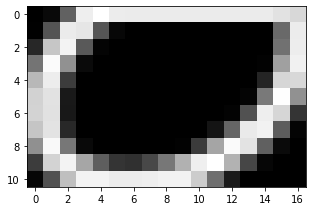

In [ ]:
img_obj = Image.open(template1_path).convert("L")
img_array = np.asarray(img_obj)

edge_map = edge_detect_sobel(img_array, False, figsize=(5,4))

plt.figure(figsize=(5,4))
plt.imshow(edge_map, 'gray')
plt.show()

### [Remove] CV2 edge detection

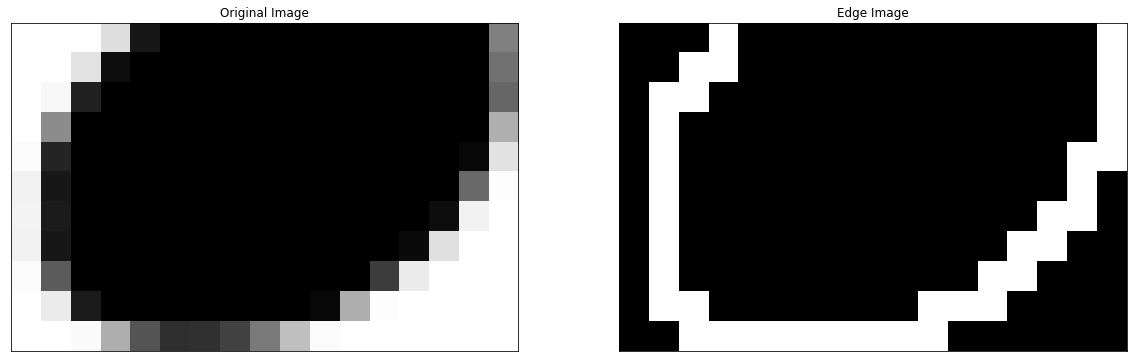

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread(template1_path,0)
edges = cv2.Canny(img,100,200)

plt.figure(figsize=(20,16))
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

### Sobel edge detection using separable convolution

In [ ]:
def edge_detect_sobel_separable(array_name, image_path, type_, with_test=False):
    edge_thresholds = {
        'template1.png': 180,
        'template2.png': 140,
        'template3.png': 140,
        'music1.png' : 160,
        'music2.png' : 120,
        'music3.png' : 220,
        'music4.png' : 160
    }
    convolved_separable_x = separable_convolve(array_name, sobel_separable_xx, sobel_separable_xy)
    convolved_separable_y = separable_convolve(array_name, sobel_separable_yx, sobel_separable_yy)
   
    edge_map_separable = np.sqrt(convolved_separable_x**2 + convolved_separable_y**2)

    print(f"DEBUG: Img size {array_name.shape} edge_map_separable size {edge_map_separable.shape}")
    
    if with_test:
        dpi = 80
        height, width = np.array(array_name.shape, dtype=float) / dpi
        fig, axs = plt.subplots(2, 2, figsize=(width, height), dpi=dpi)
        fig.tight_layout()
        axs[0,0].imshow(array_name, 'gray')
        axs[0,0].set_title("Original image")
        axs[0,1].imshow(edge_map_separable, 'gray')
        axs[0,1].set_title("Edge map of image (separable cov)")
        axs[1,0].imshow(convolved_separable_x, 'gray')
        axs[1,0].set_title("Sobel_X separable convolution")
        axs[1,1].imshow(convolved_separable_y, 'gray')
        axs[1,1].set_title("Sobel_Y separable convolution")

    if type_=='image':
        edge_map_separable = edge_map_separable / edge_map_separable.max() * 255
    edge_map_separable_theta = np.arctan2(convolved_separable_y, convolved_separable_x)
    
    threshold = edge_thresholds.get(Path(image_path).name)
    edge_map_separable = np.where(edge_map_separable>threshold, 255, 0) 
    
    return edge_map_separable, edge_map_separable_theta

### [Test] Test sobel edge detection using separable convolution

In [ ]:
def show_edge_maps(image_path, type_, save_fig=False, debug=False):
    img_obj = Image.open(image_path).convert("L")
    img_array = np.asarray(img_obj)
    edge_map_separable, edge_map_separable_theta = edge_detect_sobel_separable(img_array, image_path, type_=type_, with_test=False)
    if debug:
        if type_ == 'image':
            figsize=(20,8)
        else:
            figsize=(5,4)
        plt.figure(figsize=figsize)
        plt.imshow(edge_map_separable, 'gray')
        plt.show()
        plt.figure(figsize=figsize)
        plt.imshow(edge_map_separable_theta, 'gray')
        plt.show()
        # name = Path(image_path).stem
        # plt.savefig(name+"_edge_maps.png")
    else:
        if type_ == 'image':
            dpi = 100
            height, width = np.array(img_array.shape, dtype=float) / dpi
        else:
            dpi = 100
            height, width = 15, 8
            
        fig, axs = plt.subplots(1, 3, figsize=(width, height), dpi=dpi)
        fig.tight_layout()
        axs[0].imshow(img_array, 'gray')
        axs[0].set_title("Original image")
        axs[1].imshow(edge_map_separable, 'gray')
        axs[1].set_title("Edge map (separable)")
        axs[2].imshow(edge_map_separable_theta, 'gray')
        axs[2].set_title("Edge map theta (separable)")
        if save_fig:
            name = Path(image_path).stem
            fig.savefig(name+"_edge_maps.png", bbox_inches='tight')


DEBUG: Img size (231, 1274) edge_map_separable size (231, 1274)


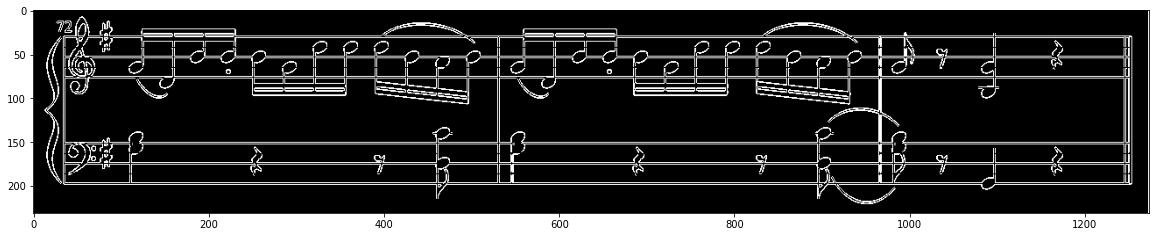

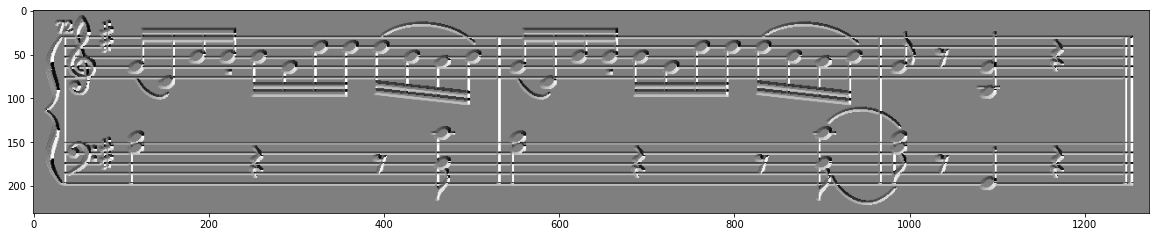

In [ ]:
show_edge_maps(image1_path, 'image', False, True)

DEBUG: Img size (11, 17) edge_map_separable size (11, 17)


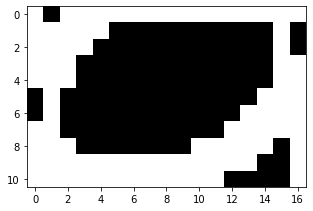

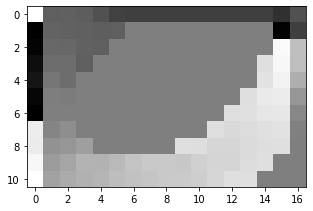

In [ ]:
show_edge_maps(template1_path, 'template', False, True)

# =======================================================================

In [ ]:
def Hamming_Distance1(image_scaled, template_scaled):
  #Padding the image to take care of boundaries 
  image_padded = np.zeros(shape=(image_scaled.shape[0] + template_scaled.shape[0] - 1, image_scaled.shape[1] + template_scaled.shape[1] -1))
  image_padded[:image_scaled.shape[0], :image_scaled.shape[1]] = image_scaled

  #Calculating Hamming distance now for template matching
  f_ij = np.zeros((image_scaled.shape[0],image_scaled.shape[1]))
  for i in range(image_scaled.shape[0]):
    for j in range(image_scaled.shape[1]):
      patch = image_padded[i:template_scaled.shape[0]+i,j:template_scaled.shape[1]+j]
      #Applying the formula given in the assignment
      f_ij[i,j] = np.sum(np.multiply(patch,template_scaled)) + np.sum(np.multiply((1-patch),(1-template_scaled)))

#   f_ij_scaled = 255*(f_ij - f_ij.min())/(f_ij.max() - f_ij.min())      
  f_ij_scaled = f_ij.astype(np.uint8)
  return(f_ij_scaled)

In [ ]:
img_obj = Image.open(image1_path).convert("L")
img_array = np.asarray(img_obj)
img_edge_map_separable, img_edge_map_separable_theta = edge_detect_sobel_separable(img_array, image1_path, type_='image', with_test=False)

tmp_obj = Image.open(template1_path).convert("L")
tmp_array = np.asarray(tmp_obj)
tmp_edge_map_separable, tmp_edge_map_separable_theta = edge_detect_sobel_separable(tmp_array, template1_path, type_='template', with_test=False)

DEBUG: Img size (231, 1274) edge_map_separable size (231, 1274)
DEBUG: Img size (11, 17) edge_map_separable size (11, 17)


In [ ]:
out = Hamming_Distance1(img_edge_map_separable, tmp_edge_map_separable)
print(f"DEBUG: output shape {out.shape}")

DEBUG: output shape (231, 1274)


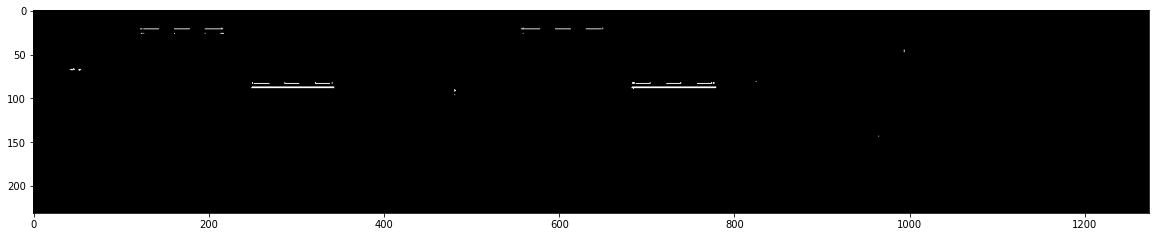

In [ ]:
plt.figure(figsize=(20,16))
plt.imshow(out, 'gray')
plt.imshow(np.where(out>200,255,0), 'gray')
plt.show()

# =======================================================================

* template 1 | Image 1 : threshold = 160

DEBUG: Img size (382, 1435) edge_map_separable size (382, 1435)


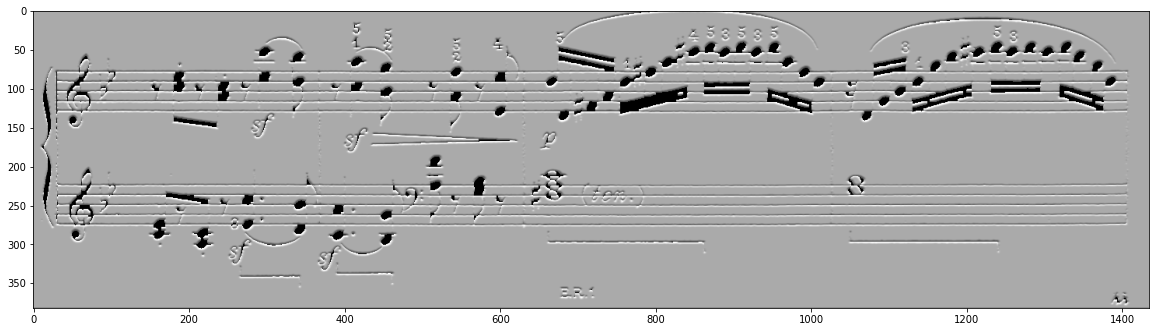

In [ ]:
show_edge_maps(image2_path, 'image', False)


In [ ]:
show_edge_maps(image3_path, 'image', False)


In [ ]:
show_edge_maps(image4_path, 'image', False)

In [ ]:
show_edge_maps(template1_path, 'template', False)
show_edge_maps(template2_path, 'template', False)
show_edge_maps(template3_path, 'template', False)

## Canny Edge detection [Optional]

## Hough transform to get locations and spacing between staves

## Hamming distance scoring on original Images

### Calculate hamming distance

In [ ]:
def Hamming_Distance(image_scaled, template_scaled):
  #Padding the image to take care of boundaries 
  image_padded = np.zeros(shape=(image_scaled.shape[0] + template_scaled.shape[0] - 1, image_scaled.shape[1] + template_scaled.shape[1] -1))
  image_padded[:image_scaled.shape[0], :image_scaled.shape[1]] = image_scaled

  #Calculating Hamming distance now for template matching
  f_ij = np.zeros((image_scaled.shape[0],image_scaled.shape[1]))
  for i in range(image_scaled.shape[0]):
    for j in range(image_scaled.shape[1]):
      patch = image_padded[i:template_scaled.shape[0]+i,j:template_scaled.shape[1]+j]
      #Applying the formula given in the assignment
      f_ij[i,j] = np.sum(np.multiply(patch,template_scaled)) + np.sum(np.multiply((1-patch),(1-template_scaled)))

  f_ij_scaled = 255*(f_ij - f_ij.min())/(f_ij.max() - f_ij.min())      
  f_ij_scaled = f_ij_scaled.astype(np.uint8)
  return(f_ij_scaled)

### Template matching function

In [ ]:
def template_matching(img_path,template_cutoff, edge_map=False, debug=False):
  #template_paths = [i[0] for i in template_cutoff]
  cutoffs = [i[1] for i in template_cutoff]
  img_array = np.array(Image.open(img_path,mode="r").convert('L'))

  if edge_map:
    image_scaled, _ = edge_detect_sobel_separable(img_array, image_path, 'image')
    if debug:
        print("DEBUG: working on this edgemap")
        plt.imshow(image_scaled, 'gray')
    templates_scaled = [template_cutoff[i][0] for i in range(len(template_cutoff))]
  else:
    image_scaled = minmax_scale(img_array)
    templates_scaled = [minmax_scale(template_cutoff[i][0]) for i in range(len(template_cutoff))]

  f_ijs = [Hamming_Distance(image_scaled,templates_scaled[i]) for i in range(len(templates_scaled))]

  if edge_map:
    print(type(f_ijs))  
    print(len(f_ijs))  
    images = f_ijs
  else:
    images = [Image.fromarray(np.where(f_ijs[i] > cutoffs[i],255,0).astype(np.uint8))  for i in range(len(f_ijs))]
  
  return(images)

### Non Maximum Supression

In [ ]:
def non_max_suppression(boxes, overlap_threshold):
    selected_boxes = []
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = (x2 - x1) * (y2 - y1)
    sort_indexes = np.argsort(x1)

    while len(sort_indexes) > 0:
        last = len(sort_indexes) - 1
        last_box = sort_indexes[last]
        selected_boxes.append(last_box)
        suppressed_boxes = [last]
 
        for i in range(0, last):
            current_box = sort_indexes[i]
 
            max_x1 = max(x1[last_box], x1[current_box])
            max_y1 = max(y1[last_box], y1[current_box])
            min_x2 = min(x2[last_box], x2[current_box])
            min_y2 = min(y2[last_box], y2[current_box])
 
            compact_box_area = float(max(0, min_x2 - max_x1)*max(0, min_y2 - max_y1))
            overlap_perc = compact_box_area/area[current_box]
            if overlap_perc > overlap_threshold:
                suppressed_boxes.append(i)

        sort_indexes = np.delete(sort_indexes, suppressed_boxes)
 
    return boxes[selected_boxes]

### Annotation function

In [ ]:
def return_notes(k):
    treble_notes = ['F','D','B','G','E']
    base_notes = ['A','F','D','B','G']
    list_notes = []
    for x in enumerate(range(row_coordinate_treble_stave,row_coordinate_treble_stave+5*spacing_parameter,spacing_parameter)):
        list_notes.append((x[1],treble_notes[x[0]]))

    for x in enumerate(range(row_coordinate_base_stave,row_coordinate_base_stave+5*spacing_parameter,spacing_parameter)):
        list_notes.append((x[1],base_notes[x[0]]))

    # print(list_notes)

    list_coordinates = [a_tuple[0] for a_tuple in list_notes]
    print(list_coordinates)

    if k > list_coordinates[0] - spacing_parameter/2 and k <=list_coordinates[0]+spacing_parameter/2:
        text = 'F'
        return(text)
    elif k > list_coordinates[1] - spacing_parameter/2 and k <=list_coordinates[1]+spacing_parameter/2:
        text = 'D'
        return(text)

    elif k > list_coordinates[2] - spacing_parameter/2 and k <=list_coordinates[2]+spacing_parameter/2:
        text = 'B'
        return(text)

    elif k > list_coordinates[3] - spacing_parameter/2 and k <=list_coordinates[3]+spacing_parameter/2:
        text = 'G'
        return(text)

    elif k > list_coordinates[4] - spacing_parameter/2 and k <=list_coordinates[4]+spacing_parameter/2:
        text = 'E'
        return(text)

    elif k > list_coordinates[5] - spacing_parameter/2 and k <=list_coordinates[5]+spacing_parameter/2:
        text = 'A'
        return(text)
    
    elif k > list_coordinates[6] - spacing_parameter/2 and k <=list_coordinates[6]+spacing_parameter/2:
        text = 'F'
        return(text)

    elif k > list_coordinates[7] - spacing_parameter/2 and k <=list_coordinates[7]+spacing_parameter/2:
        text = 'D'
        return(text)

    elif k > list_coordinates[8] - spacing_parameter/2 and k <=list_coordinates[8]+spacing_parameter/2:
        text = 'B'
        return(text)

    elif k > list_coordinates[8] - spacing_parameter/2 and k <=list_coordinates[8]+spacing_parameter/2:
        text = 'G'
        return(text)

    else:
        text = ''
        return(text)

### Template cutoff function

In [ ]:
def setup_template_cutoffs(image_path):
    if image_path == image1_path:
        music_cutoffs = [220,240,240]
    elif image_path == image2_path:
        music_cutoffs = [230,235,235]

    # im = Image.open(image_path,mode='r').convert('L')
    temp1 = Image.open(template1_path,mode="r").convert('L')
    temp2 = Image.open(template2_path,mode="r").convert('L')
    temp3 = Image.open(template3_path,mode="r").convert('L')

    # im_array = np.array(im)
    temp_array1 = np.array(temp1)
    temp_array2 = np.array(temp2)
    temp_array3 = np.array(temp3)

    template_cutoff = [(temp_array1,music_cutoffs[0]),(temp_array2,music_cutoffs[1]),(temp_array3,music_cutoffs[2])]
    return template_cutoff


### Display output function

In [ ]:
def show_output(image_path, images, template_cutoff):
    colors = ['red','green','blue']
    convert_image = Image.open(image_path).convert('L')
    im1 = convert_image.convert('RGB')
    draw = ImageDraw.Draw(im1)
    coordinates = [(0,0)]
    for k in range(len(images)):
        #path = template_cutoff[k][0]
        temp_array_1 = template_cutoff[k][0]
        #temp_array_1 = np.array(Image.open(path,mode="r").convert('L'))
        temp = np.array(images[k])
        box_endpoints = []
        for i in range(temp.shape[0]):
            for j in range(temp.shape[1]):
                if temp[i,j] == 255:
                    x = i
                    y = j
                    x2 = x + temp_array_1.shape[0]
                    y2 = y + temp_array_1.shape[1]
                    box_endpoints.append([y,x,y2,x2])

        boxes_out = non_max_suppression(boxes=np.array(box_endpoints), overlap_threshold=0.3)
        for box in boxes_out:
            draw.rectangle(((box[0],box[1]),(box[2],box[3])), outline= colors[k] ,width=2) 
            # text = return_notes(box[1])
            # if k ==0:
            #     draw.text((box[0]-5,box[1]-5), text, fill='red')
            # elif k ==1:
            #     draw.text((box[0]-10,box[1]-10), 'quarter rest', fill='green')
            # elif k ==2:
            #     draw.text((box[0]-10,box[1]-10), 'eighth rest', fill='green')
    return im1

### Apply template matching on original images and generate output image

In [ ]:
template_cutoff =  setup_template_cutoffs(image1_path)   

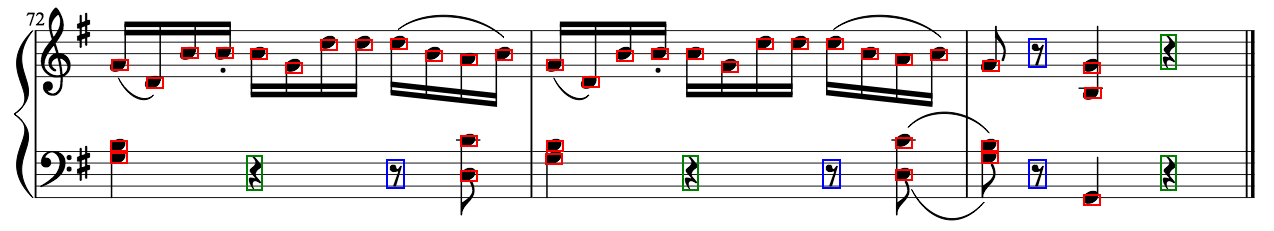

In [ ]:
template_matched_images = template_matching(image1_path,template_cutoff)
# for i in template_matched_images:
#     plt.figure(figsize=(20,16))
#     plt.imshow(i, 'gray')
#     plt.show()
im1 = show_output(image1_path, template_matched_images, template_cutoff)
im1

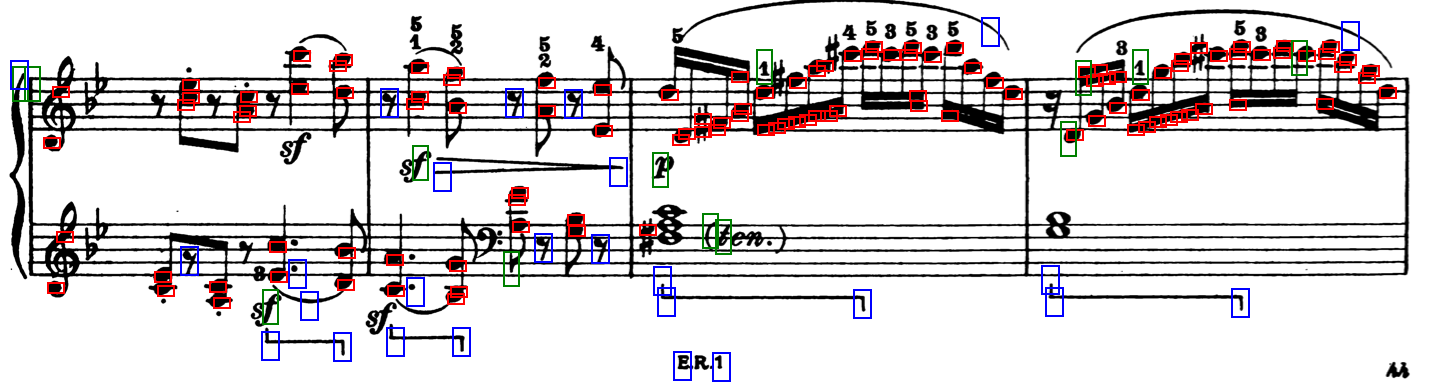

In [ ]:
template_matched_images = template_matching(image2_path,template_cutoff)
im2 = show_output(image2_path, template_matched_images, template_cutoff)
im2

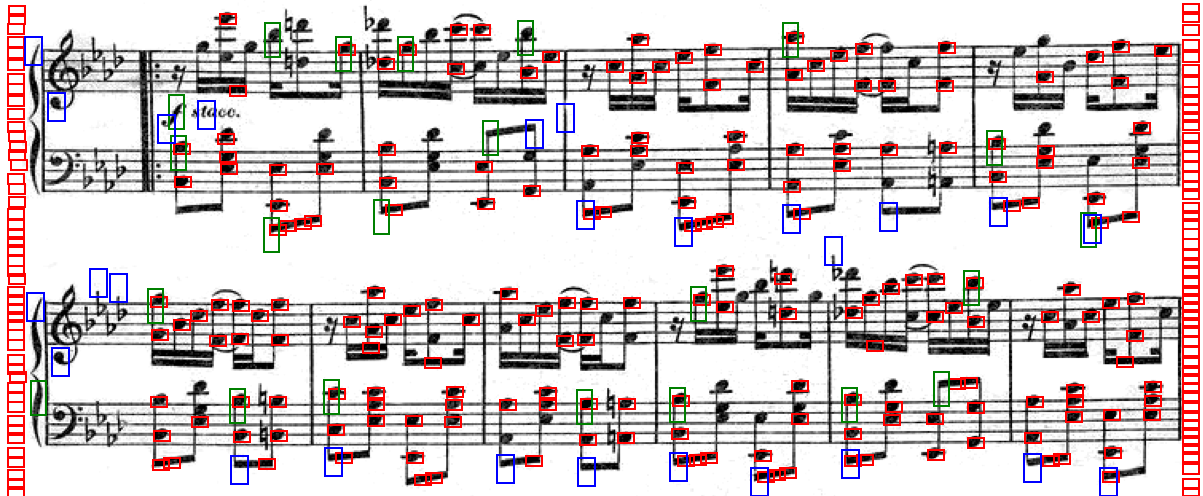

In [ ]:
template_matched_images = template_matching(image3_path,template_cutoff)
im3 = show_output(image3_path, template_matched_images, template_cutoff)
im3

## Hamming distance scoring on sobel edge maps

### Template cutoffs for edge maps

In [ ]:
def setup_template_cutoffs_edgemaps(image_path):
    if image_path == image1_path:
        music_cutoffs = [160,240,240]
    elif image_path == image2_path:
        music_cutoffs = [230,235,235]

    # im = Image.open(image_path,mode='r').convert('L')
    temp1 = Image.open(template1_path,mode="r").convert('L')
    temp2 = Image.open(template2_path,mode="r").convert('L')
    temp3 = Image.open(template3_path,mode="r").convert('L')

    # im_array = np.array(im)
    temp_array1 = np.array(temp1)
    temp_array2 = np.array(temp2)
    temp_array3 = np.array(temp3)

    em_temp_array1, _ = edge_detect_sobel_separable(temp_array1, template1_path, 'template', with_test=False)
    em_temp_array2, _ = edge_detect_sobel_separable(temp_array2, template2_path, 'template', with_test=False)
    em_temp_array3, _ = edge_detect_sobel_separable(temp_array3, template3_path, 'template', with_test=False)

    template_cutoff = [(em_temp_array1,music_cutoffs[0]),(em_temp_array2,music_cutoffs[1]),(em_temp_array3,music_cutoffs[2])]

    return template_cutoff

In [ ]:
em_template_cutoff =  setup_template_cutoffs_edgemaps(image1_path)   

DEBUG: Img size (11, 17) edge_map_separable size (11, 17)
DEBUG: Img size (35, 16) edge_map_separable size (35, 16)
DEBUG: Img size (29, 18) edge_map_separable size (29, 18)


In [ ]:
em_template_matched_images = template_matching(image1_path,em_template_cutoff, edge_map=True)

DEBUG: Img size (231, 1274) edge_map_separable size (231, 1274)
<class 'list'>
3


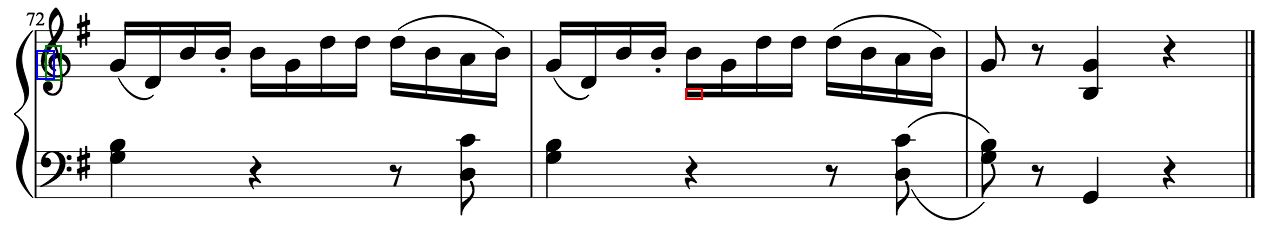

In [ ]:
em_im1 = show_output(image1_path, em_template_matched_images, em_template_cutoff)
em_im1

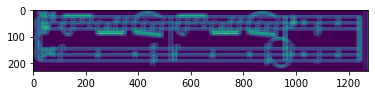

In [ ]:
plt.imshow(em_template_matched_images[0])

## [Temorary section] Download files

In [ ]:
! ls -lrt

total 592
drwxr-xr-x 1 root root   4096 Mar 18 13:36 sample_data
drwxr-xr-x 2 root root   4096 Mar 27 22:39 test-images
-rw-r--r-- 1 root root 203232 Mar 27 23:12 music3_edge_maps.png
-rw-r--r-- 1 root root 190682 Mar 27 23:12 music4_edge_maps.png
-rw-r--r-- 1 root root  21915 Mar 28 00:39 template2_edge_maps.png
-rw-r--r-- 1 root root  18605 Mar 28 00:39 template3_edge_maps.png
-rw-r--r-- 1 root root  12847 Mar 28 01:20 template1_edge_maps.png
-rw-r--r-- 1 root root 123204 Mar 28 01:26 music2_edge_maps.png
-rw-r--r-- 1 root root  12273 Mar 28 01:32 music1_edge_maps.png


In [ ]:
files.download('music1_edge_maps.png')
# files.download('music2_edge_maps.png')
# files.download('music3_edge_maps.png')
# files.download('music4_edge_maps.png')

# files.download('template1_edge_maps.png')
# files.download('template2_edge_maps.png')
# files.download('template3_edge_maps.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# NEW OMR Class

In [ ]:
class omr:
    """
    Optical Music Recognition class
    """

    sobel_sx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]]) 
    sobel_sy = np.array([[1,2,1],[0,0,0],[-1,-2,-1]]) 
    
    sobel_separable_xx = np.array([[1],[2],[1]])
    sobel_separable_xy = np.array([[1,0,-1]])
    sobel_separable_yx = np.array([[1],[0],[-1]])
    sobel_separable_yy = np.array([[1,2,1]])


    sobel_separable_x = np.array([[1,0,-1]])
    sobel_separable_y = np.array([[1,2,1]])
    

    def __init__(self, img_name, img_location=".", with_test=False) -> None:
        """
        Constructor method
        Args:
            img_name (str): name of the image. ex. music1.png
            img_location (str, optional): Location of the image. Defaults to "."
                                          ex. ./test-images
            with_test (bool, optional): Compare with standard libraries. 
                                        Defaults to False.
        """
        self.img_name = img_name
        self.img_file = Path(img_location, img_name)
        self.with_test = with_test
        self.img_obj = Image.open(self.img_file).convert("L")
        self.img_array = np.asarray(self.img_obj)
#        self.img_array = minmax_scale(np.asarray(self.img_obj)).astype(np.uint8)
        self.img_width = self.img_obj.width
        self.img_height = self.img_obj.height

        # parameters for Canny Edge Detector
        self.weak_pixel = 75       # 100
        self.strong_pixel = 255
        self.lowThreshold = 0.05   # 0.05
        self.highThreshold = 0.15  # 0.09 or 0.15 or 0.19
    
    def return_img_array(self):
        return self.img_obj, self.img_array

    def return_tmp_img_array(self, tmp_img_name, tmp_img_location="."):
        self.tmp_img_name = tmp_img_name
        self.tmp_img_file = Path(tmp_img_location, tmp_img_name)

        self.tmp_img_obj = Image.open(self.tmp_img_file).convert("L")
        self.tmp_img_array = np.asarray(self.tmp_img_obj)
#        self.tmp_img_array = minmax_scale(np.asarray(self.tmp_img_obj)).astype(np.uint8)
        self.tmp_img_width = self.tmp_img_obj.width
        self.tmp_img_height = self.tmp_img_obj.height
        return self.tmp_img_array, self.tmp_img_obj, self.tmp_img_width, self.tmp_img_height

    def convolve(self, array_name, kernel):
        """
        Method to perform 2D convolution of self.img_array and kernel.
        Args:
            kernel (np.Array): Kernel to used for the convolution.
        Return:
            Array resulted after the convolution having shape same as input 
            image array.
        """
        kernel_rows, kernel_cols = kernel.shape
        self.array_name = array_name
        img_rows, img_cols = self.array_name.shape

        print("image shape: ", self.array_name.shape)

        # flip the kernel
#        flipped_kernel = np.zeros(kernel.shape)
       
        ## column flips
#        for i in range(flipped_kernel.shape[1]):
#            flipped_kernel[:,i] = kernel[:,kernel_cols-i-1]
#        kernel = flipped_kernel.copy()

        ## row flips
#        for i in range(flipped_kernel.shape[0]):
#            flipped_kernel[i,:] = kernel[kernel_rows-i-1,:]
#        kernel = flipped_kernel.copy()
#        print("Flipped kernel:\n", kernel)

        # Handle broders by padding the image with white pixels.
        ## padwidth = kernel_rows // 2 
        r_pad = kernel_rows // 2
        c_pad = kernel_cols // 2
        self.array_name_padded = np.pad(self.array_name, pad_width=((r_pad,r_pad),(c_pad,c_pad)), \
                                        mode='constant', constant_values=255)
        
        # cross correlation
        self.array_name_out = np.zeros(self.array_name.shape)

        for x in range(img_rows):
            for y in range(img_cols):
                self.array_name_out[x, y] = \
                (np.multiply(np.flip(kernel), self.array_name_padded[x:x+kernel_rows, y:y+kernel_cols])).sum()
        
        return self.array_name_out


    def separable_convolve(self, array_name, h_kernel, v_kernel):
        """
        Method to perform 2D convolution in the horizontal and then vertical direction of self.img_array and kernel.
        Args:
            h_kernel (np.Array): Kernel used in the horizontal direction for the convolution.
            v_kernel (np.Array): Kernel used in the vertical direction for the convolution.
        Return:
            Array resulted after the convolution having shape same as input 
            image array.
        """
        kernel_rows, kernel_cols = h_kernel.shape
        img_rows, img_cols = self.img_array.shape

        # Handle broders by padding the image with white pixels.
        padwidth = kernel_cols // 2
        self.img_array_padded = np.pad(self.img_array, padwidth, 
                                    mode='constant', constant_values=255)
        
        # convoution in the horizontal direction
        self.img_array_out_tmp = np.zeros((self.img_array.shape[0]+h_kernel.shape[1]-1, self.img_array.shape[1]))
        for y in range(img_cols):
            for x in range(img_rows):
                self.img_array_out_tmp[x, y] = \
                (h_kernel * self.img_array_padded[x, y:y+h_kernel.shape[1]]).sum()

        # convoution in the horizontal direction
        self.img_array_out = np.zeros(self.img_array.shape)

        for y in range(img_cols):
            for x in range(img_rows):
                self.img_array_out[x, y] = \
                (v_kernel * self.img_array_out_tmp[x:x+v_kernel.shape[1], y]).sum()
        
#         print("Convolved image:\n", self.img_array_out.shape)
        return self.img_array_out

        
    def edge_detect_sobel(self, array_name, figsize=(10,8)):
        """
        Method to perform edge detection using sobel operator and 2D convolution
        """
        self.convolved_x = self.convolve(array_name, omr.sobel_sx)
        self.convolved_y = self.convolve(array_name, omr.sobel_sy)
        self.edge_map = np.sqrt(np.power(self.convolved_x,2) + np.power(self.convolved_y,2))
        
        if self.with_test:
            fig, axs = plt.subplots(2, 2, figsize=figsize)
            axs[0,0].imshow(array_name, 'gray')
            axs[0,0].set_title("Original image")
            axs[0,1].imshow(self.edge_map, 'gray')
            axs[0,1].set_title("Edge map of image")
            axs[1,0].imshow(self.convolved_x, 'gray')
            axs[1,0].set_title("Sobel_X convolution")
            axs[1,1].imshow(self.convolved_y, 'gray')
            axs[1,1].set_title("Sobel_Y convolution")
  
        self.edge_map = self.edge_map / self.edge_map.max() * 255
        self.edge_map_theta = np.arctan2(self.convolved_y, self.convolved_x)
        return self.edge_map, self.edge_map_theta
    
    def edge_detect_sobel_separable(self, array_name, figsize=(10,8)):
        """
        Method to perform edge detection using sobel operator and separable kernel convolutions
        """
        self.convolved_separable_x = self.separable_convolve(array_name, omr.sobel_separable_x,omr.sobel_separable_y)
        self.convolved_separable_y = self.separable_convolve(array_name, omr.sobel_separable_y,omr.sobel_separable_x)

        self.edge_map_separable = np.sqrt(self.convolved_separable_x**2 + self.convolved_separable_y**2)
       
        if self.with_test:
            fig, axs = plt.subplots(2, 2, figsize=figsize)
            axs[0,0].imshow(array_name, 'gray')
            axs[0,0].set_title("Original image")
            axs[0,1].imshow(self.edge_map_separable, 'gray')
            axs[0,1].set_title("Edge map of image (separable cov)")
            axs[1,0].imshow(self.convolved_separable_x, 'gray')
            axs[1,0].set_title("Sobel_X separable convolution")
            axs[1,1].imshow(self.convolved_separable_y, 'gray')
            axs[1,1].set_title("Sobel_Y separable convolution")

        self.edge_map_separable = self.edge_map_separable / self.edge_map_separable.max() * 255
        self.edge_map_separable_theta = np.arctan2(self.convolved_separable_y, self.convolved_separable_x)
        self.edge_map_separable = np.where(self.edge_map_separable>140, 255, 0)
        return self.edge_map_separable, self.edge_map_separable_theta


image shape:  (35, 16)
image shape:  (35, 16)
image shape:  (35, 16)
image shape:  (35, 16)


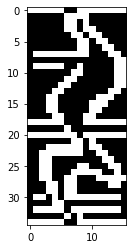

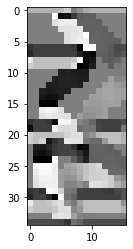

In [ ]:
tmp2_omr = omr(template2_path)
em, em_theta = tmp2_omr.edge_detect_sobel_separable(tmp2_omr.img_array)
plt.figure(figsize=(8,4))
plt.imshow(em, 'gray')
plt.show() 
plt.imshow(em_theta, 'gray')
plt.show() 

In [ ]:
omr_img_obj = omr(image1_path)
img_edge_map_separable, img_edge_map_separable_theta = omr_img_obj.edge_detect_sobel_separable(omr_img_obj.img_array)

omr_tmp_obj = omr(template1_path)
tmp_edge_map_separable, tmp_edge_map_separable_theta = omr_tmp_obj.edge_detect_sobel_separable(omr_tmp_obj.img_array)

In [ ]:
np.max(img_edge_map_separable)

1

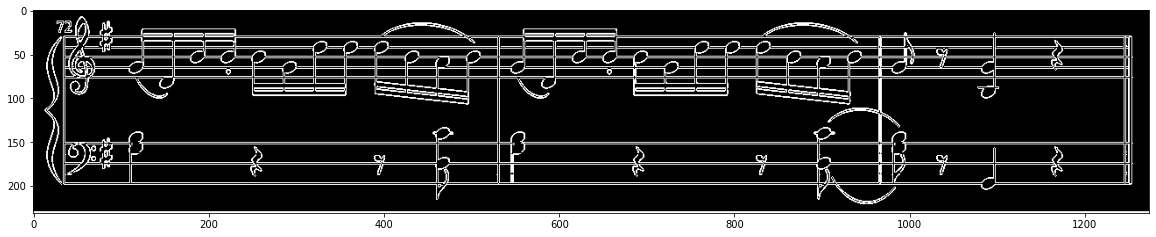

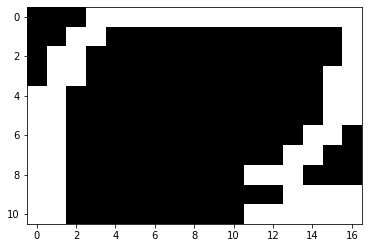

In [ ]:
plt.figure(figsize=(20,16))
plt.imshow(img_edge_map_separable, 'gray')
plt.show()
# plt.figure(figsize=(5,4))
plt.imshow(tmp_edge_map_separable, 'gray')
plt.show()

In [ ]:
out = Hamming_Distance1(img_edge_map_separable, tmp_edge_map_separable)
print(f"DEBUG: output shape {out.shape}")

DEBUG: output shape (231, 1274)


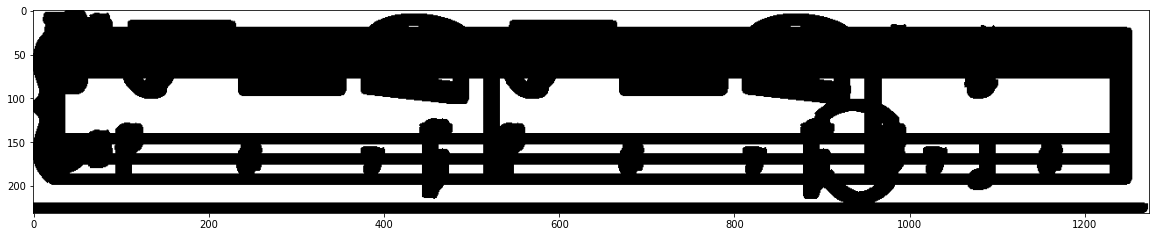

In [ ]:
plt.figure(figsize=(20,16))
plt.imshow(out, 'gray')
plt.imshow(np.where(out>200,255,0), 'gray')
plt.show()